In [1]:
%pip install python-dotenv


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /usr/local/bin/python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os
import warnings
import dotenv
# load env vars from .env file
dotenv.load_dotenv()

warnings.filterwarnings('ignore')
dir_path = os.getcwd()
parent_directory = os.path.dirname(dir_path)
sys.path.insert(0, f'{parent_directory}/helpers')
os.environ["ROOT_DIR"] = parent_directory
REDIS_URL = os.getenv("REDIS_URL")

print("========== ENVIRONMENT VARIABLES ==========")
print(f"Current Directory={dir_path}")
print(f"Parent Directory={parent_directory}")
print(f"System path={sys.path}")
print("---------------------------------")
print(f'LLM Engine: {os.getenv("LOCAL_LLM_ENGINE")}')
print(f'LOCAL_VLLM_MODEL: {os.getenv("LOCAL_VLLM_MODEL")}')
print(f'LOCAL_OLLAMA_MODEL: {os.getenv("LOCAL_OLLAMA_MODEL")}')
print(f'VLLM_URL: {os.getenv("VLLM_URL")}')
print("---------------------------------")
print(f"NLTK_DATA={os.getenv('NLTK_DATA')}")

========== ENVIRONMENT VARIABLES ==========
Current Directory=/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop/4_data_evaluations
Parent Directory=/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop
System path=['/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop/helpers', '/Users/rouzbeh.farahmand/PycharmProjects/boa-financial-rag-workshop', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages']
---------------------------------
LLM Engine: ollama
LOCAL_VLLM_MODEL: meta-llama/Meta-Llama-3-8B-Instruct
LOCAL_OLLAMA_MODEL: llama3:8b
VLLM_URL: http://localhost:8000/v1
---------------------------------
NLTK_DATA=


In [3]:
%pip install -U scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /usr/local/bin/python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /usr/local/bin/python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
from utils import *
from ingestion import *
from custom_ners import *
import pandas as pd

sec_data = get_sec_data()


def add_chunks_to_df(chunks_to_process, ldf):
    contents = []
    for i, chunk in enumerate(chunks_to_process):
        content = str(chunk.page_content)
        contents.append(content)
    new_data = pd.DataFrame({
    'chunk': contents
    })
    ldf = pd.concat([ldf,new_data])
    
    return ldf

def create_df(data_dict, tickers=None):
    df = pd.DataFrame({'chunk': []})
    
    if tickers is None:
        tickers = list(data_dict.keys())

    for ticker in tickers:
        if len(data_dict[ticker]["metadata_file"]) > 0:
            shared_metadata = load_json_metadata(data_dict[ticker]["metadata_file"][0])

        for filing_file in data_dict[ticker]["10K_files"]:
            filing_file_filename = str(filing_file).split("/")[len(str(filing_file).split("/")) - 1]
            fchunks = get_chunks(filing_file)
            df = add_chunks_to_df(fchunks, df)
        
        for earning_file in data_dict[ticker]["transcript_files"]:
            earning_file_filename = str(earning_file).split("/")[len(str(earning_file).split("/")) - 1]
            echunks = get_chunks(earning_file)
            df = add_chunks_to_df(echunks, df)
            
    return df

mydf = create_df(sec_data, tickers=['AAPL'])

mydf.head(4)

 ✅ Loaded doc info for  111 tickers...
 ✅ Loaded doc info for  111 tickers...


,chunk
0,UNITED STATES SECURITIES AND EXCHANGE COMMISSI...
1,California (State or other jurisdiction of inc...
2,1.000% Notes due 2022 1.375% Notes due 2024 0....
3,Name of each exchange on which registered The ...


In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [7]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corresponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#stop-words
stop_words=set(['a','an']) #set(nltk.corpus.stopwords.words('english'))

In [8]:
def clean_text(headline):
  le=WordNetLemmatizer()
  word_tokens=word_tokenize(headline)
  tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3]
  cleaned_text=" ".join(tokens)
  return cleaned_text

In [9]:
#mydf['chunk']=mydf['chunk'].apply(clean_text)

In [10]:
vectorizer = TfidfVectorizer()
vectorizer =TfidfVectorizer(stop_words=list(stop_words),max_features=1000) # to play with. min_df,max_df,max_features etc...


In [11]:
vect_text=vectorizer.fit_transform(mydf['chunk'])
vectorizer.get_feature_names_out()

array(['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '10',
       '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1b',
       '20', '200', '2014', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', '2023', '2024', '2025', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '300', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '3b', '40', '408', '41', '42', '43',
       '44', '45', '451', '46', '47', '48', '49', '4b', '50', '500', '51',
       '52', '53', '54', '55', '56', '57', '58', '59', '5b', '60', '68',
       '7b', '85', '8b', '90', '974', '99', '9b', 'aapl', 'ability',
       'able', 'about', 'accelerated', 'access', 'accessories',
       'accompanying', 'accordance', 'accounted', 'accounting',
       'accounts', 'across', 'act', 'actions', 'active', 'activities',
       'actual', 'actually', 'addition', 'additional', 'adverse',
       'adversely', 'advertising', 'affect', 'affected', 'after', 'again',
       '

In [12]:
print(vect_text.shape)
print(vect_text)

(4636, 1000)
  (0, 941)	0.1461725174555283
  (0, 860)	0.14413038694249455
  (0, 807)	0.32078066379086606
  (0, 137)	0.03257362499825736
  (0, 361)	0.33418777266101074
  (0, 234)	0.2766585596771437
  (0, 397)	0.09435923490414463
  (0, 10)	0.08089432521140268
  (0, 567)	0.13363003617785668
  (0, 634)	0.09666440724175078
  (0, 139)	0.1293176368422184
  (0, 761)	0.25067203948328376
  (0, 726)	0.28097988012936503
  (0, 924)	0.1162048842507249
  (0, 806)	0.28097988012936503
  (0, 14)	0.20504303333345175
  (0, 644)	0.19330759896412902
  (0, 16)	0.20359641099652276
  (0, 626)	0.17359498234952464
  (0, 901)	0.1402894700438602
  (0, 103)	0.25254636967811855
  (0, 395)	0.10032332678443576
  (0, 387)	0.12826079957225703
  (0, 992)	0.08215456660029853
  (0, 343)	0.1293176368422184
  :	:
  (4635, 137)	0.05501353687136822
  (4635, 924)	0.06541940690463872
  (4635, 644)	0.10882561912894972
  (4635, 901)	0.1184673172441738
  (4635, 645)	0.12728125092964526
  (4635, 124)	0.12890397271228723
  (4635, 237

In [13]:
idf=vectorizer.idf_

dd=dict(zip(vectorizer.get_feature_names_out(), idf))
l=sorted(dd, key=(dd).get)
# print(l)
print(l[0],l[-1])

and court


In [14]:
from sklearn.decomposition import TruncatedSVD
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10, random_state=42)

lsa_top=lsa_model.fit_transform(vect_text)

In [15]:
print(lsa_top)
print(lsa_top.shape)  # (no_of_doc*no_of_topics)

[[ 0.24477686 -0.17494118  0.06497302 ...  0.11155636 -0.08822998
  -0.04704494]
 [ 0.14675172 -0.11503872  0.02393884 ...  0.04916696 -0.05544951
  -0.09161976]
 [ 0.02862852 -0.04897972  0.00819743 ...  0.26460487  0.68534019
  -0.36478646]
 ...
 [ 0.2866655  -0.15987939 -0.04784074 ...  0.08136994 -0.19211121
  -0.26812745]
 [ 0.32338402 -0.24546369 -0.04905014 ... -0.019561   -0.21457323
  -0.30946369]
 [ 0.17706038 -0.1725195  -0.02544214 ... -0.05986437 -0.10815817
  -0.16303164]]
(4636, 10)


In [16]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
  print("Topic ",i," : ",topic*100)

Document 0 :
Topic  0  :  24.47768567733407
Topic  1  :  -17.494117567114653
Topic  2  :  6.497302178473769
Topic  3  :  -1.086471929631208
Topic  4  :  1.1065234474520078
Topic  5  :  -15.72766253922503
Topic  6  :  5.190381971689698
Topic  7  :  11.155635528391981
Topic  8  :  -8.822997739115975
Topic  9  :  -4.704493552230189


In [17]:
#most important words for each topic
vocab = vectorizer.get_feature_names_out()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
the and of sync id to we time in 00 

Topic 1: 
sync id 00 time we you that so re it 

Topic 2: 
inc apple ceo cook director timothy senior maestri cfo luca 

Topic 3: 
research analyst division md cross llc senior co morgan huberty 

Topic 4: 
company the or sync id 00 could adversely may its 

Topic 5: 
we that you cook ceo it timothy so think director 

Topic 6: 
maestri cfo luca vp senior we inc that the apple 

Topic 7: 
notes we the september 2022 2021 due that billion as 

Topic 8: 
notes due products dated services we representing global and forms 

Topic 9: 
we and sales company net our products services billion 2021 



In [18]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 
# n_components is the number of topics

In [19]:
lda_top=lda_model.fit_transform(vect_text)

In [20]:
print(lda_top.shape)  # (no_of_doc,no_of_topics)
print(lda_top)

(4636, 10)
[[0.01583442 0.01583599 0.85745865 ... 0.01583401 0.01583916 0.01583917]
 [0.01612982 0.01613297 0.01619947 ... 0.01613009 0.0161415  0.01622785]
 [0.03277379 0.03276937 0.70506177 ... 0.03276939 0.03277341 0.0327695 ]
 ...
 [0.01771924 0.01772111 0.0177195  ... 0.01772112 0.01771959 0.84051949]
 [0.01466458 0.01466606 0.01466505 ... 0.01466492 0.014666   0.79325414]
 [0.01763875 0.01763966 0.01764037 ... 0.01763878 0.0176396  0.64262856]]


In [21]:
sum=0
for i in lda_top[0]:
  sum=sum+i
print(sum)  

1.0


In [22]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(lda_top[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  1.5834422425956598 %
Topic  1 :  1.583598589776613 %
Topic  2 :  85.74586516132702 %
Topic  3 :  1.5836733341123066 %
Topic  4 :  1.5836465122281156 %
Topic  5 :  1.5839747422492638 %
Topic  6 :  1.5845656740454253 %
Topic  7 :  1.5834010566990055 %
Topic  8 :  1.5839160266783134 %
Topic  9 :  1.5839166602882957 %


In [23]:
print(lda_model.components_)
print(lda_model.components_.shape)  # (no_of_topics*no_of_words)

[[ 0.12390176  0.90491988  0.11456306 ...  0.1168262   0.42328713
   0.15194682]
 [ 0.13210231  0.11561148  0.11071067 ...  0.1147862   0.11535392
   1.19208134]
 [ 1.79997983  2.97850778  0.13886929 ...  0.12225594  0.19102889
   0.59537648]
 ...
 [ 0.24835651  0.11682448  0.11525987 ...  0.15590495  0.18871451
   2.17997136]
 [ 1.55566247  0.18717668  0.11554971 ...  5.25880043 34.40735168
   0.38171515]
 [ 0.17864907  0.1548663   0.11696476 ...  0.1267954   0.12024605
   1.72134622]]
(10, 1000)


In [24]:
# most important words for each topic
vocab = vectorizer.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
china india card europe middle rest co commercial markets greater 

Topic 1: 
the company stated and materially upon risks or future of 

Topic 2: 
notes due of sales the states net united and total 

Topic 3: 
the that time and we to of in it is 

Topic 4: 
sync id 00 research you analyst division time we operator 

Topic 5: 
review cash of billion the shares 408 for share tax 

Topic 6: 
inc cook apple ceo director timothy maestri luca cfo vp 

Topic 7: 
business have follow could results condition the adversely operations company 

Topic 8: 
revenue qtr iphone in co year new growth apple ipad 

Topic 9: 
the any or company and applicable forward to of looking 



In [25]:
%pip install wordcloud


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /usr/local/bin/python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):
  imp_words_topic=""
  comp=lda_model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()
 

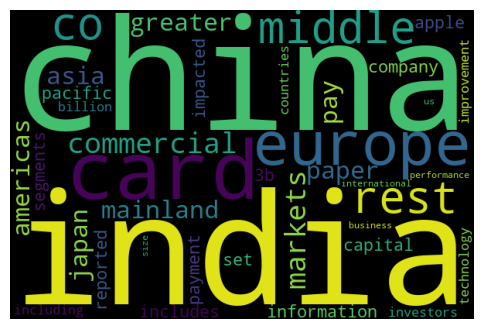

In [28]:
# topic 0
draw_word_cloud(0)